# BLUE (Best Linear Unbiased Estimator) for Disk Formation
> Created March. 2025 <br>
> Nikhil Bisht<br>

In [4]:
#import modules
import yt
yt.utilities.logger.disable_stream_logging()
from all_utilities import *
import numpy as np
import h5py

#define paths
SCRATCH = "/home/nbisht/scratch"
NATURE_RUN = SCRATCH + "/data_assimilation/DiskFormation_9Level_PPM/"
LOWRES_RUN = SCRATCH + "/data_assimilation/DiskFormation_3Level_PPM/"
ANALYSIS_RUN = SCRATCH + "/data_assimilation/DiskFormation_3Level_analysis/"

NATURE_RUN_INITIAL_CONDITIONS = "./DiskFormation_9Level_PPM/DiskFormation_9Level_PPM.enzo"
LOWRES_RUN_INITIAL_CONDITIONS = "./DiskFormation_3Level_PPM/DiskFormation_9Level_PPM.enzo"
ANALYSIS_RUN_INITIAL_CONDITIONS = "./DiskFormation_3Level_analysis/DiskFormation_3Level_analysis.enzo"      #Same as LOWRES RUN

path_to_output_plots = "./plots/"

ALL_FIELDS = ['Density', 'Temperature', 'TotalEnergy', 'x-velocity', 'y-velocity', 'z-velocity']


## Visualize Nature run and low resolution run

In [5]:
#simulation_visualize(path_to_output_plots,'Density_xy_NatureRun_PPM',NATURE_RUN, 'z', ('gas', 'density'), 31, cbar_range = [1e-2, 1e+3])
simulation_visualize(path_to_output_plots,'Density_xy_LowResRun_PPM',LOWRES_RUN, 'z', ('gas', 'density'), 31, cbar_range = [1e-2, 1e+3])

Parsing Hierarchy : 100%|██████████| 46/46 [00:00<00:00, 8263.93it/s]


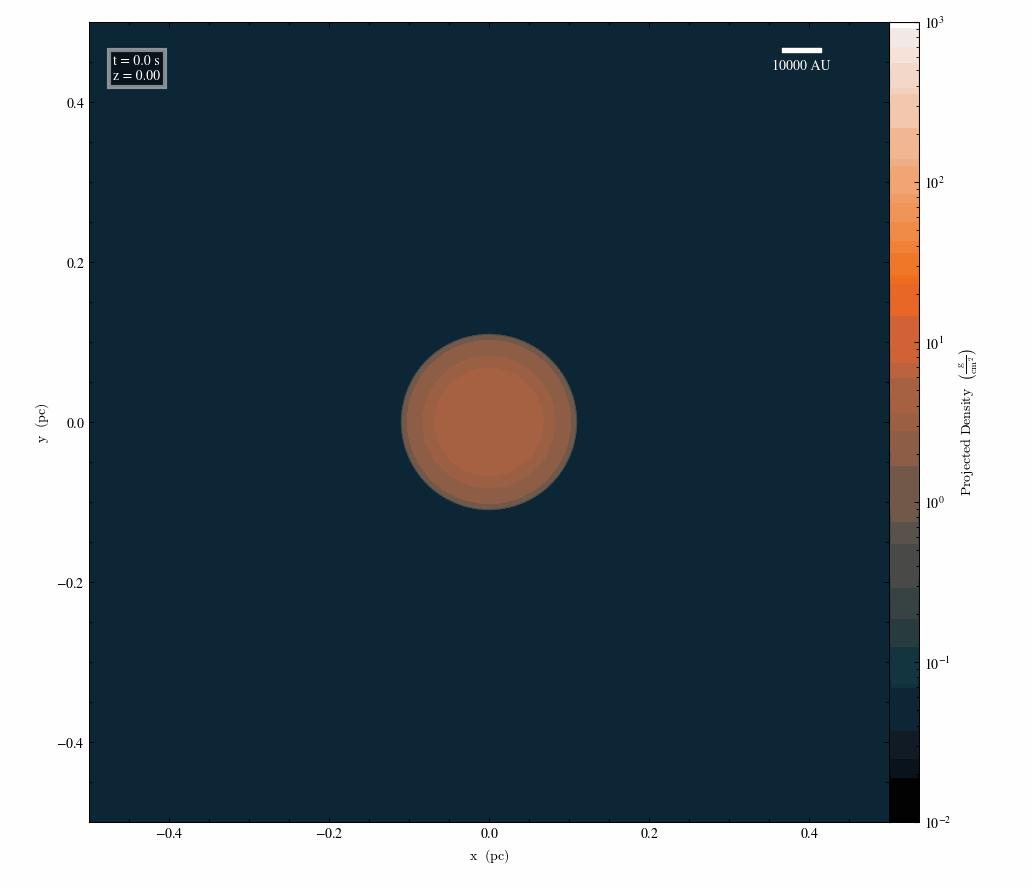

In [3]:
Image(filename=path_to_output_plots+'Density_xy_NatureRun_PPM'+'.gif')

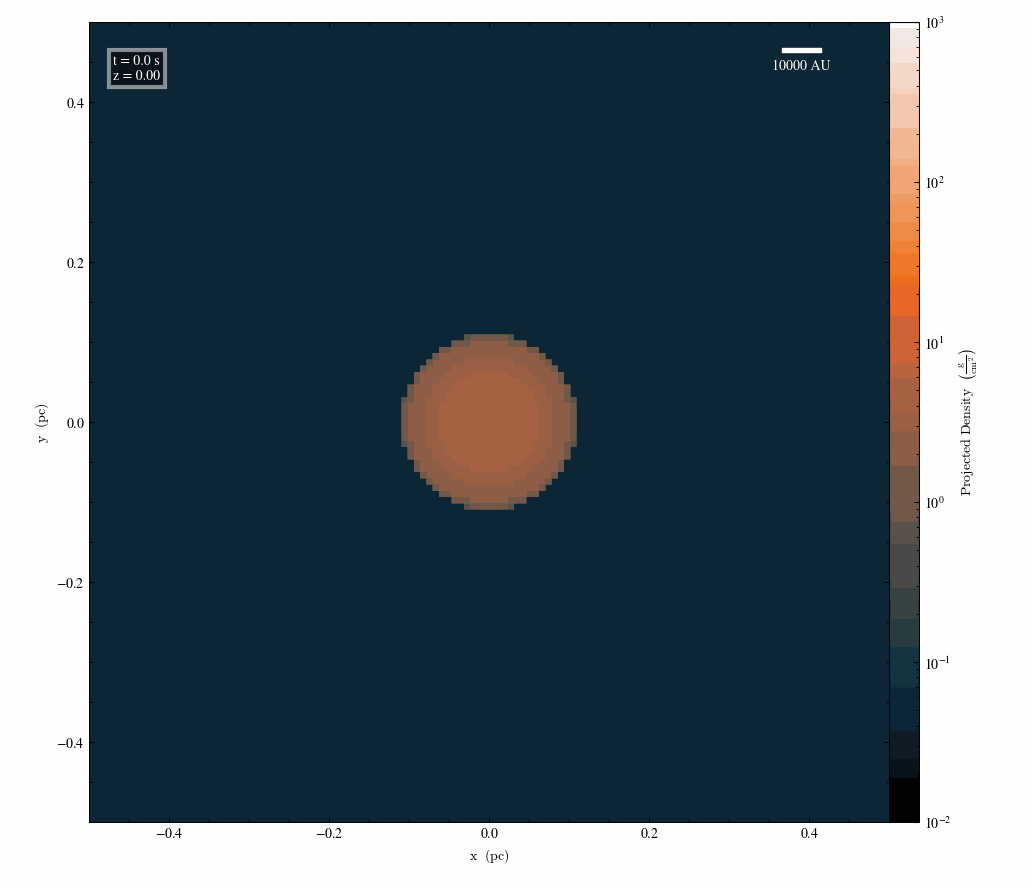

In [6]:
Image(filename=path_to_output_plots+'Density_xy_LowResRun_PPM'+'.gif')

## DA

### Setup

In [7]:
#simulation parameters
START_TIME = 0.0
STOP_TIME = 6.0
dt_DATADUMP = 0.2
ALL_FRAMES = np.arange(START_TIME,STOP_TIME+dt_DATADUMP, dt_DATADUMP)
OBSERVATION_TIMES = [1.0, 3.0, 4.0]

#BLUE solution parameters
alpha_pos = 0.5
beta_pos = 0.5
alpha_vel = 0.5
beta_vel = 0.5
alpha_mag = 0.5
beta_mag = 0.5

Parsing Hierarchy : 100%|██████████| 89/89 [00:00<00:00, 8305.74it/s]


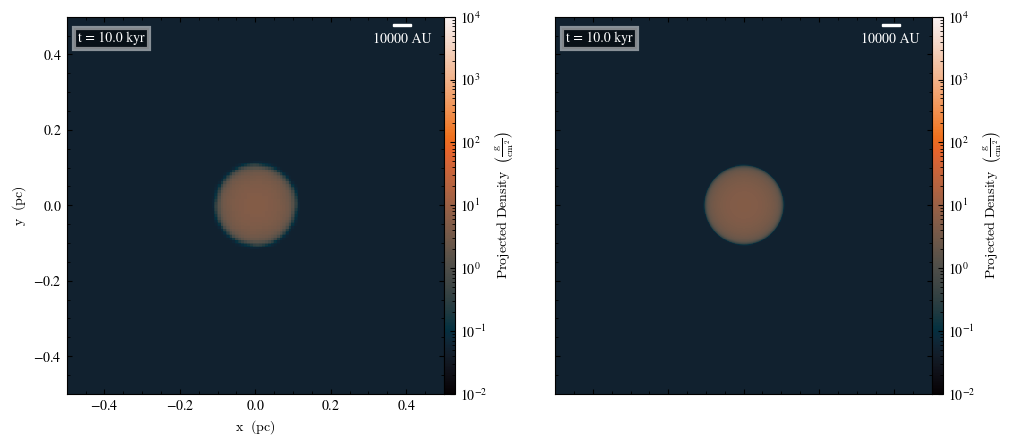

Parsing Hierarchy : 100%|██████████| 124/124 [00:00<00:00, 5924.23it/s]


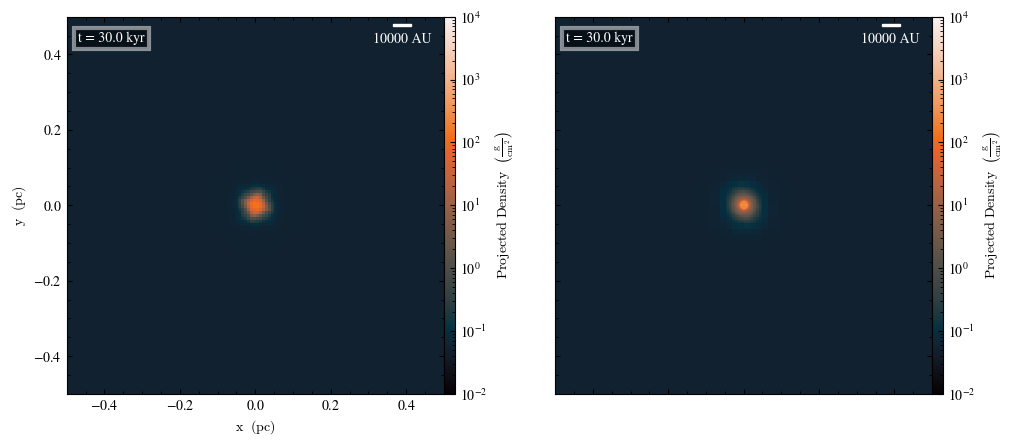

Parsing Hierarchy : 100%|██████████| 367/367 [00:00<00:00, 7288.54it/s]


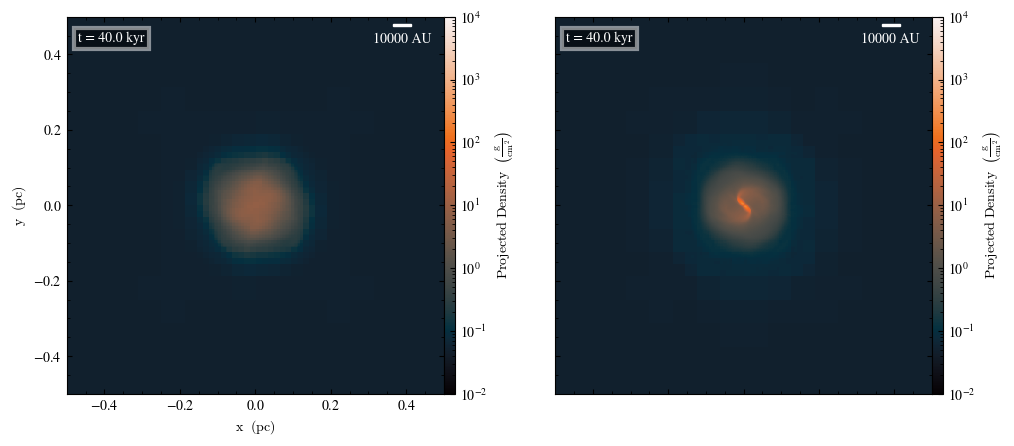

In [8]:
#Compare the two runs for the observation times
simulation_comparison(LOWRES_RUN, NATURE_RUN, OBSERVATION_TIMES[0], ALL_FRAMES, path_to_output_plots)
simulation_comparison(LOWRES_RUN, NATURE_RUN, OBSERVATION_TIMES[1], ALL_FRAMES, path_to_output_plots)
simulation_comparison(LOWRES_RUN, NATURE_RUN, OBSERVATION_TIMES[2], ALL_FRAMES, path_to_output_plots)

### Generating Synthetic Observations
$\boldsymbol{E}^o_n \sim \mathcal{N}(0,\mathbf{R}_n)$ are the Gaussian, unbiased observation errors with covariance $\mathbf{R}_n$. 

$\;$ 

For our problem, the choose the following:

* $\mathbf{R}_n = \sigma_o^2 = (0.1)^2$: the observation error variance is fixed to 0.1 at all times for each grid point

In [ ]:
#Generate the synthetic observations at all times
np.random.seed(10)
def generate_observations(input_arr, error_std):
    return input_arr+ np.random.normal(0.0,error_std,size=input_arr.size) # second arg is sigma

### Forecasting

In [ ]:
def edit_enzo_param_file(file_name, new_time):
    analysis_enzo_param_file = h5py.File(ANALYSIS_RUN +grid_data['BaryonFileName'], "a")
    return 0

run_simulation(ANALYSIS_RUN, restart_datadump = None, path_to_initial_conditions = ANALYSIS_RUN_INITIAL_CONDITIONS, num_processors = 8)

### Analysis

In [13]:
#The core analysis function that does the linear combination of observation and background
def data_analysis_step(background_arr, observation_arr, alpha, beta):
    return alpha*background_arr+beta*observation_arr

In [14]:
#open analysis simulation files one by one
#grab grid points for each case, use yt to get values in the nature run
#modify and store the modified values
#run the simulation
obs_time = OBSERVATION_TIMES[0]
frame_num = str(np.where(ALL_FRAMES==obs_time)[0][0]).zfill(4)
#Load the data from nature run
data_nature = yt.load(NATURE_RUN+"/Data/DD"+frame_num+"/DD"+frame_num)
code_length = data_nature.length_unit.in_units("code_length")
#Load the data from analysis run
#param file has all initial conditions and simulation parameters
analysis_param_file = open(ANALYSIS_RUN + 'Data/DD'+frame_num+'/DD'+frame_num, 'r')
NumberOfGhostZones    = 5
#boundary file has boundary parameters
analysis_bdry_file = open(ANALYSIS_RUN + 'Data/DD' + frame_num+'/DD' + frame_num+'.boundary', 'r')
#Not needed in this case but maybe for other periodic boxes?
analysis_bdry_hdf = h5py.File(ANALYSIS_RUN +'Data/DD' + frame_num+'/DD' + frame_num+'.boundary.hdf', "r")
print("Boundary HDF5 Keys: %s" % analysis_bdry_hdf.keys())

#hierarchy file has grid structure; main iterator
analysis_hrchy_file = open(ANALYSIS_RUN + 'Data/DD' + frame_num+'/DD' + frame_num+'.hierarchy', 'r')
grid_dict = read_hierarchy_file(analysis_hrchy_file)
for gridnum in list(grid_dict.keys()):
    grid_data = grid_dict[gridnum]
    print("Working on grid: "+str(gridnum))
    GridDimReal = np.array(grid_data['GridDimension'])-2*NumberOfGhostZones
    x_gp = np.linspace(grid_data['GridLeftEdge'][0], grid_data['GridRightEdge'][0], GridDimReal[0]+1)*code_length
    y_gp = np.linspace(grid_data['GridLeftEdge'][1], grid_data['GridRightEdge'][1], GridDimReal[1]+1)*code_length
    z_gp = np.linspace(grid_data['GridLeftEdge'][2], grid_data['GridRightEdge'][2], GridDimReal[2]+1)*code_length
    X,Y,Z = np.meshgrid((x_gp[1:]+x_gp[:-1])/2, (y_gp[1:]+y_gp[:-1])/2, (z_gp[1:]+z_gp[:-1])/2)
    gridpoints = np.vstack(list(zip(X.ravel(), Y.ravel(),  Z.ravel())))
    #Let's get the actual baryon data now
    analysis_datadump_hdf = h5py.File(ANALYSIS_RUN +grid_data['BaryonFileName'], "a")
    print("DataDump HDF5 Keys: %s" % analysis_datadump_hdf.keys())
    Gridstr = 'Grid'+ str(gridnum).zfill(8)
    print(analysis_datadump_hdf[Gridstr].keys())
    print("Field:",end=' ')
    for field in ALL_FIELDS:
      print("%s " % field, end=' ')
      field_data = analysis_datadump_hdf[Gridstr][field][()]
      field_data_nature_run = data_nature.find_field_values_at_points([('enzo',field)],gridpoints).reshape((field_data.shape)).to_ndarray()
      if (field_data.shape!=field_data_nature_run.shape):
        print("Shape Mismatch!")
        exit      
      #They are ordered the same and for the same grids! Now to do the update
      field_data_assimilated = data_analysis_step(np.array(field_data), field_data_nature_run, 0.5, 0.5)
      analysis_datadump_hdf[Gridstr][field][()] = field_data_assimilated.tolist()
    analysis_datadump_hdf.close()
    print(' ')

analysis_param_file.close()
analysis_bdry_file.close()
analysis_bdry_hdf.close()
analysis_hrchy_file.close()
data_nature = None

Boundary HDF5 Keys: <KeysViewHDF5 ['BoundaryDimensionType.0', 'BoundaryDimensionType.1', 'BoundaryDimensionType.2', 'BoundaryDimensionValue.0', 'BoundaryDimensionValue.1', 'BoundaryDimensionValue.2']>
Working on grid: 1
DataDump HDF5 Keys: <KeysViewHDF5 ['Grid00000001', 'Grid00000009', 'Grid00000010', 'Grid00000011', 'Metadata']>
<KeysViewHDF5 ['Density', 'Temperature', 'TotalEnergy', 'x-velocity', 'y-velocity', 'z-velocity']>
Field: Density



Parsing Hierarchy : 100%|██████████| 89/89 [00:00<00:00, 9118.50it/s]



Field: Temperature


Field: TotalEnergy


Field: x-velocity


Field: y-velocity


Field: z-velocity


Working on grid: 2
DataDump HDF5 Keys: <KeysViewHDF5 ['Grid00000002', 'Grid00000024', 'Grid00000025', 'Metadata']>
<KeysViewHDF5 ['Density', 'Temperature', 'TotalEnergy', 'x-velocity', 'y-velocity', 'z-velocity']>
Field: Density


Field: Temperature


Field: TotalEnergy


Field: x-velocity


Field: y-velocity


Field: z-velocity


Working on grid: 3
DataDump HDF5 Keys: <KeysViewHDF5 ['Grid00000003', 'Grid00000022', 'Grid00000023', 'Metadata']>
<KeysViewHDF5 ['Density', 'Temperature', 'TotalEnergy', 'x-velocity', 'y-velocity', 'z-velocity']>
Field: Density


Field: Temperature


Field: TotalEnergy


Field: x-velocity


Field: y-velocity


Field: z-velocity


Working on grid: 4
DataDump HDF5 Keys: <KeysViewHDF5 ['Grid00000004', 'Grid00000020', 'Grid00000021', 'Metadata']>
<KeysViewHDF5 ['Density', 'Temperature', 'TotalEnergy', 'x-velocity', 'y-velocity', 'z-velocity']>
Field: Density




### Putting it all together

In [ ]:
### Initial estimates and covariances
x0 = np.array([-np.pi/2, 3.0]) 
P0 = np.eye(2) # identity matrix of size 2
Q = np.diag([0.1, 0.1]) # covariance of the model errors; assumed constant in time
R = np.array([[0.1]]) # covariance of the observation errors; assumed constant in time

## Visualizing DA solution and comparison with nature run

In [16]:
simulation_visualize(path_to_output_plots,'Density_xy_AnalysisRun_PPM',ANALYSIS_RUN, 'z', ('gas', 'density'), 16, cbar_range = [1e-2, 1e+3])

Parsing Hierarchy : 100%|██████████| 27/27 [00:00<00:00, 7623.95it/s]


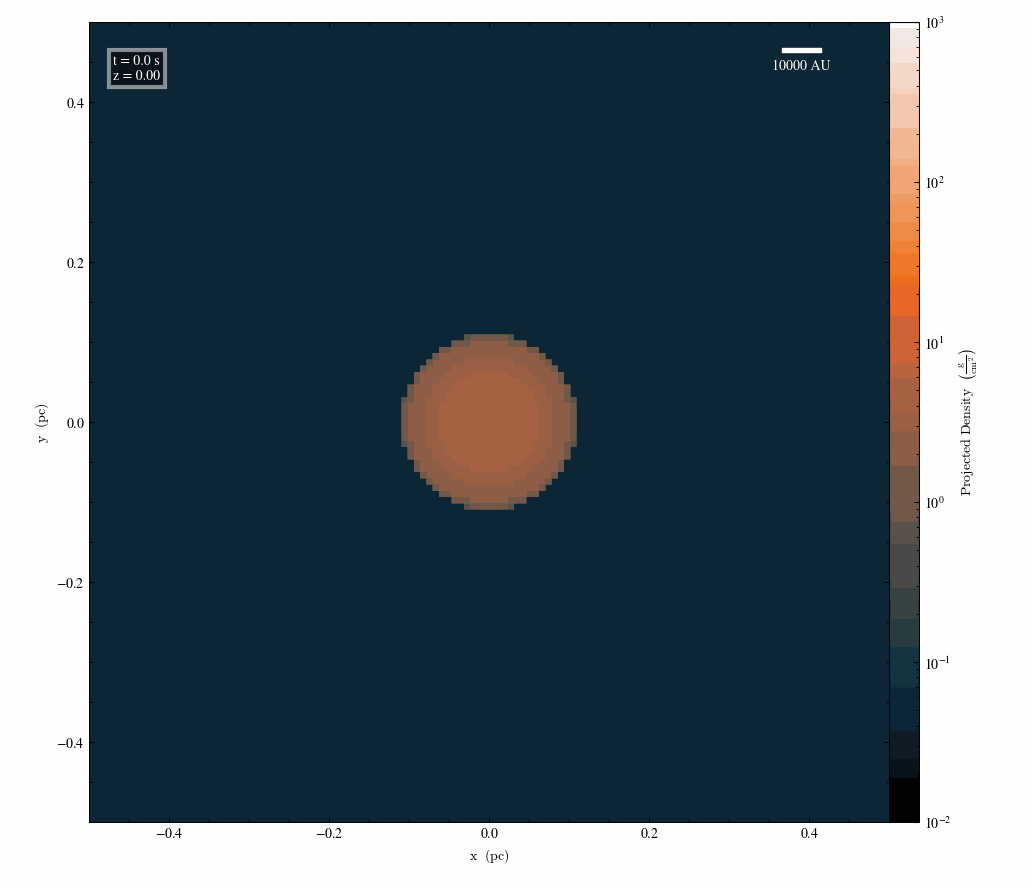

In [18]:
Image(filename=path_to_output_plots+'Density_xy_AnalysisRun_PPM'+'.gif')